In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import halfnorm, kstest, ks_2samp

In [2]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [3]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [4]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

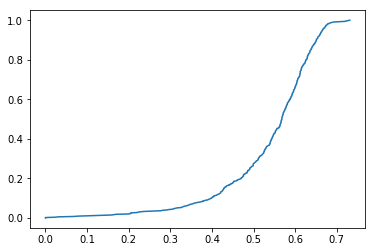

In [5]:
sort_y = np.sort(planets_etamb)
p = np.linspace(0, 1, len(planets_etamb))
data_CDF = lambda x: np.interp(x, sort_y, p)

plt.figure(1)
plt.plot(sort_y, p)
plt.show()

In [13]:
def draw_samp(x, m, b, yerr_mu, yerr_sig, scatter_mu, scatter_sig, bias_mu, bias_sig):
    result = []
    yerr = np.random.normal(yerr_mu, yerr_sig, size = len(x))
    scatter = np.random.normal(scatter_mu, scatter_sig, size = len(x))
    bias = halfnorm.rvs(bias_mu, bias_sig, size = len(x))
#         print(yerr, scatter, bias)
    result = yerr + scatter - bias + (m*x + b)
    return np.array(result)

In [15]:
def calc1000pval(m, b, yerr_mu, yerr_sig, scatter_mu, scatter_sig, bias_mu, bias_sig):
    stats = []
    for i in range(1000):
        trial = draw_samp(days, m, b, yerr_mu, yerr_sig, scatter_mu, scatter_sig, bias_mu, bias_sig)
        ks_stat = ks_2samp(planets_etamb, trial)
        stats.append(ks_stat[1])
    return stats

print(calc1000pval(m, b, yerr_mu, yerr_sig, scatter_mu, scatter_sig, bias_mu, bias_sig))

[6.4818582886826476e-19, 5.9869973995489882e-12, 3.9447312864154054e-13, 8.6378173241446932e-17, 3.6955276837229185e-14, 3.1573463731286576e-15, 1.1875588810939906e-19, 6.9040403525179277e-16, 3.6955276837229185e-14, 5.9158607444980277e-18, 1.1328696200978935e-18, 2.9884856729942166e-17, 1.4604262743275074e-16, 2.9884856729942807e-17, 2.2761803773013084e-14, 6.4818582886828315e-19, 1.546972632976707e-13, 1.9091928089113767e-15, 2.4748580431508105e-13, 1.0188170829423008e-17, 6.9040403525179277e-16, 6.2644655524290746e-13, 1.9726943401575724e-18, 1.7481309568011572e-17, 1.5624842025736739e-12, 2.9884856729942807e-17, 1.0188170829423008e-17, 3.8401228843923382e-12, 5.0901181366444746e-17, 3.6955276837228132e-14, 3.4224659483321411e-18, 1.1875588810939906e-19, 4.1288517612766125e-16, 6.519844503583292e-21, 3.6955276837228132e-14, 2.2761803773013084e-14, 5.9778596493037636e-14, 4.1288517612766125e-16, 1.4604262743275074e-16, 1.1328696200979097e-18, 1.9091928089113767e-15, 1.396806860283998

In [8]:
# plt.figure(figsize=(12, 7))
# plt.plot(days, planets_etamb, 'bx')
# plt.plot(days, trial, 'rx')
# plt.xlabel('days')
# plt.ylabel('sampled values')
# plt.show()

In [32]:
num_trials = 5
m = np.linspace(-.1, .1, num=num_trials)
b = np.linspace(.5, .65, num=num_trials)
yerr_mu = np.linspace(0.0, .01, num=num_trials)
yerr_sig = np.linspace(.01, .05, num=num_trials)
scatter_mu = np.linspace(0.0, .01, num=num_trials)
scatter_sig = np.linspace(.01, .05, num=num_trials)
bias_mu = np.linspace(0.0, .01, num=num_trials)
bias_sig = np.linspace(0.0, .1, num=num_trials)

In [ ]:
a, B, c, d, e = np.meshgrid(m, b, yerr_sig, scatter_sig, bias_sig)
arr = np.stack((np.ravel(a), np.ravel(B), np.ravel(c), np.ravel(d), np.ravel(e)), axis=-1)
# print(arr)
results = {}
for i in arr:
    results[str(i)] = calc1000pval(i[0], i[1], 0.0, i[2], 0.0, i[3], 0.0, i[4])
# print(results)